In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
#from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.python.framework import ops
from sklearn.metrics import f1_score, precision_score, recall_score
ops.reset_default_graph()
random.seed(271828)
np.random.seed(271828)
#import tensorflow as tf
from imblearn.over_sampling import SMOTE
tf.random.set_seed(271828)
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import KMeans,DBSCAN, MeanShift
import matplotlib.pyplot as plt

https://towardsdatascience.com/multitask-learning-teach-your-ai-more-to-make-it-better-dde116c2cd40

In [9]:
targets_dict = {
    'q6.1_INTRU': 1,
    'q6.2_DREAM': 1,
    'q6.3_FLASH': 1,
    'q6.4_UPSET': 0,
    'q6.5_PHYS': 0,
    'q6.6_AVTHT': 0,
    'q6.7_AVSIT': 0,
    'q6.8_AMNES': 0,
    'q6.9_DISINT': 0,
    'q6.10_DTACH': 0,
    'q6.11_NUMB': 0,
    'q6.12_FUTRE': 0,
    'q6.13_SLEEP': 0,
    'q6.14_ANGER': 0,
    'q6.15_CONC': 0,
    'q6.16_HYPER': 0,
    'q6.17_STRTL': 0,
    'intrusion_cutoff': 0,
    'avoidance_cutoff': 0,
    'hypertention_cutoff': 0,
    'depression_cutoff':0,
    'only_avoidance_cutoff': 0,
    'regression_cutoff_33': 0,
    'regression_cutoff_50': 0,
    'tred_cutoff': 1,
}

In [10]:
questions = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS',
                 'q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE', 'q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC',
                 'q6.16_HYPER', 'q6.17_STRTL']
targets_list = [i for i in targets_dict if targets_dict[i] == 1]


In [11]:

def PCL_calculator(df):

    symptomatic_cutoff = 2

    intrusion = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS']
    avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE']
    tred = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH']
    only_avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES']

    hypertension = ['q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC', 'q6.16_HYPER', 'q6.17_STRTL']

    depression = ['q6.9_DISINT', 'q6.10_DTACH', 'q6.11_NUMB', 'q6.12_FUTRE']

    df[intrusion + avoidance + hypertension].fillna(df[intrusion + avoidance + hypertension].mean(axis=1))
    intrusion_cuoff = 1
    avoidance_cuoff = 3
    hypertension_cuoff = 2
    only_avoidance_cutoff = 1
    depression_cutoff = 2
    tred_cutoff = 1

    df['sum'] = (df[intrusion + avoidance + hypertension]).sum(axis=1)

    df['intrusion'] = (df[intrusion] > symptomatic_cutoff).sum(axis=1)
    df['intrusion_cutoff'] = df['intrusion'] >= intrusion_cuoff

    df['avoidance'] = (df[avoidance] > symptomatic_cutoff).sum(axis=1)
    df['avoidance_cutoff'] = df['avoidance'] >= avoidance_cuoff

    df['depression'] = (df[depression] > symptomatic_cutoff).sum(axis=1)
    df['depression_cutoff'] = df['depression'] >= depression_cutoff

    df['hypertention'] = (df[hypertension] > symptomatic_cutoff).sum(axis=1)
    df['hypertention_cutoff'] = df['hypertention'] >= hypertension_cuoff

    df['tred'] = (df[tred] > symptomatic_cutoff).sum(axis=1)
    df['tred_cutoff'] = df['tred'] >= tred_cutoff

    df['only_avoidance'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_cutoff'] = df['only_avoidance'] >= only_avoidance_cutoff

    df['regression_cutoff_33'] = df['sum'] >= 33
    df['regression_cutoff_50'] = df['sum'] >= 50
    df['diagnosis'] = ((df['hypertention_cutoff']) & (df['avoidance_cutoff']) & (df['intrusion_cutoff']) & (df['sum'] >= 50))

    return df



In [12]:

class PTSD_Model:

    features = ["age", "highschool_diploma", "dyslexia", "ADHD", "T1Acc1t", "T1Acc1n", "T1bias", "phq1", "lot1",
                "trait1",
                "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2", "trait2", "state2", "PCL2", "PCL_Broad2",
                "PCL_Strict2", "cd_risc1", "active_coping1", "planning1", "positive_reframing1", "acceptance1",
                "humor1",
                "religion1", "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2", "planning2",
                "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                "instrumental_support2",
                "self_distraction2", "denial2", "venting2", "substance_use2", "behavioral_disengagement2",
                "self_blame2",
                "trauma_history8_1", "HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5"]

    features_2 = ['q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1',
                  'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                  'intrusion_pcl1', 'avoidance_pcl1', 'hypertention_pcl1', 'depression_pcl1', 'tred_pcl1',
                  'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2',
                  'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
                  'intrusion_pcl2', 'avoidance_pcl2', 'hypertention_pcl2', 'depression_pcl2', 'tred_pcl2']
    target_features = ["PCL_Strict3", "PCL3"]
    target_features_2 = ["intrusion_cutoff", "avoidance_cutoff", "hypertention_cutoff",
                         'depression_cutoff', 'diagnosis', "PCL3", "only_avoidance_cutoff", "tred_cutoff",
                         "regression_cutoff_33", "regression_cutoff_50"]
    ID = ["ID"]
    dataset_path = r"../Data/PTSD.xlsx"

    multiple_features_no_imputation = ['q6.16_HYPER_pcl1',  'hypertention_pcl2', 'q6.5_PHYS_pcl2', 'q6.12_FUTRE_pcl1',
                                       'cd_risc1',  'q6.2_DREAM_pcl2',  'q6.14_ANGER_pcl2', 'positive_reframing2',
                                       'venting2', 'q6.15_CONC_pcl1', 'q6.8_AMNES_pcl1',
                                       'q6.15_CONC_pcl2', 'PCL_Broad2', 'phq2', 'q6.4_UPSET_pcl2']

    def __init__(self):
        path = "C:\‏‏PycharmProjects\PTSD\Data\PTSD.xlsx"
        df = pd.read_excel(path)
        df = df[~df['PCL_Strict3'].isna()]
        #df = df[~ ((df["military_exp18_t3"] == 0) & (df["military_exp18_t2"] == 0))]
        df = df[self.features + self.ID + self.target_features]
        df_pcl3 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL3.xlsx")
        df_pcl3 = PCL_calculator(df_pcl3)
        df_pcl2 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL2.xlsx")
        df_pcl2 = PCL_calculator(df_pcl2)
        df_pcl1 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL1.xlsx")
        df_pcl1 = PCL_calculator(df_pcl1)

        df = df.merge(df_pcl1, on="ID", how='outer')
        df = df.merge(df_pcl2, suffixes=('_pcl1', '_pcl2'), on="ID", how='outer')
        df = df.merge(df_pcl3.drop(['PCL3_Strict', 'pcl3', 'PCL3_Broad'], axis=1), on="ID", how='outer')

        df = df[~df['PCL_Strict3'].isna()]
        #df = df[~df['tred_cutoff'].isna()]
        df.drop(self.ID, inplace=True, axis=1)
        mice = IterativeImputer()
        df = pd.DataFrame(mice.fit_transform(df), columns=df.columns)

        all_x_col = self.features + self.features_2 + self.target_features_2 + questions
        #all_x_col = self.features + self.features_2
        #y_col = ["tred_cutoff"]
        y_col = ["PCL_Strict3"]
        X = df[all_x_col]
        Y = df[y_col]
        X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, Y, test_size=0.25, random_state=271828, stratify=Y)
        X_train, X_test, y_train, y_test = train_test_split(X_train_0, y_train_0, test_size=0.25, random_state=271828, stratify=y_train_0)
        df = pd.concat([X_train, y_train], axis=1)
        self.X_test = X_test
        self.y_test =y_test

        self.X_train_0 = X_train_0
        self.X_test_0 = X_test_0
        self.y_train_0 = y_train_0
        self.y_test_0 = y_test_0

        self.df = df


In [13]:
m = PTSD_Model()
X = m.df.drop("PCL_Strict3", axis=1)
Y01 = m.df["PCL_Strict3"].apply(lambda x: int(x))

features = m.features + m.features_2


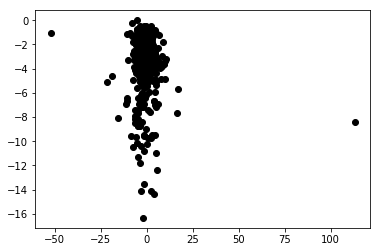

In [15]:
SRP = SparseRandomProjection(n_components=154,density = 'auto', eps = 0.5, random_state=2019, dense_output = False)
X_srp = SRP.fit_transform(X[features])


km = DBSCAN(eps=9, min_samples=100)#n_clusters=4)
km = km.fit(X[features])
one_0 = X_srp[:, 0][(km.labels_==0)]
one_1 = X_srp[:, 1][(km.labels_==0)]
#one_2 = s[:, 2][(km.labels_==0)]
plt.scatter(one_0, one_1,  c='r')
#ax.scatter(one_0, one_1, one_2,  c='r')

one_0 = X_srp[:, 0][(km.labels_==1)]
one_1 = X_srp[:, 1][(km.labels_==1)]
#one_2 = s[:, 2][(km.labels_==1)]

plt.scatter(one_0, one_1,  c='b')
#ax.scatter(one_0, one_1, one_2, c='c')

one_0 = X_srp[:, 0][(km.labels_==2)]
one_1 = X_srp[:, 1][(km.labels_==2)]
#one_2 = s[:, 2][(km.labels_==2)]

plt.scatter(one_0, one_1,  c='y')
#ax.scatter(one_0, one_1, one_2, c='y')

one_0 = X_srp[:, 0][(km.labels_==-1)]
one_1 = X_srp[:, 1][(km.labels_==-1)]
#one_2 = s[:, 2][(km.labels_==3)]

plt.scatter(one_0, one_1,  c='k')
#ax.scatter(one_0, one_1, one_2, c='g')
X["new"] = km.labels_
features.append("new")

In [19]:
for lim in [0.5, 0.75]:
    print(f"____________ Limit = {lim} ______________")
    kfold = StratifiedKFold(n_splits=10, shuffle=True)

    train_scores_f = []
    train_scores_p = []
    train_scores_r = []

    scores_f = []
    scores_p = []
    scores_r = []
    for train, test in kfold.split(X, Y01):
        
        Y1 = X['tred_cutoff'].apply(lambda x: int(x > 0))
        X_train = X.iloc[train]
        y_train_1 = X_train['tred_cutoff'].apply(lambda x: int(x > 0))
        sm = SMOTE(random_state=27)
        cols = X_train.columns
        X_train, y_train_1 = sm.fit_sample(X_train, y_train_1.ravel())
        X_train = pd.DataFrame(X_train, columns=cols)
        y_trains = []
        for i in targets_list:
            y_trains.append(X_train[i].apply(lambda x: int(x > 0)))
        y_trains.append(y_train_1)

        X_train = X_train[features]

        visible = Input(shape=(103,))
        #x = Dense(30, activation='relu')(visible)
        #x = Dropout(0.5)(x)
        #x = Dropout(0.1)(x)

        #x = Dense(20, activation='relu')(visible)
        #x = Dropout(0.5)(x)
        #x = Dropout(0.1)(x)
        x = Dense(20, activation='relu')(visible)
        x = Dropout(0.25)(x)
        outputs = []
        
        for i in targets_list:
            outputs.append(Dense(1, activation='sigmoid')(x))
        x = Dense(10, activation='relu')(visible)
        x = Dropout(0.25)(x)
        #x = Dropout(0.1)(x)
        outputs.append(Dense(1, activation='sigmoid')(x))
        #outputs = [output1, output2, output3, output4, output5, output6,
         #          output7, output8, output9, output10, output11,
          #         output12, output13, output14, output15, output16,
           #        output17, output18, output19, output20, output21,
            #       output22, output23, output24, output25, output26]
        
        
        model = Model(inputs=visible, outputs=outputs)
        #callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
        model.compile(loss=['binary_crossentropy']+['binary_crossentropy'] * len(targets_list),
              optimizer=Adam(), loss_weights =  ([1e-1] * len(targets_list)) + [1])
        
        model.fit(X_train,y_trains , epochs = 200, verbose=0,
                 #class_weight= [{1:10, 0:1}, 2{1:2, 0:1}, {1:2, 0:1}, {1:2, 0:1}]
                 )
        # evaluate the model
        y_pred = (model.predict(X[features].iloc[test])[0] > lim).astype(int)

        s_f = f1_score(Y1.iloc[test], y_pred)
        s_p = precision_score(Y1.iloc[test], y_pred)
        s_r = recall_score(Y1.iloc[test], y_pred)
        print(f"sum(Y1.iloc[test]) = {sum(Y1.iloc[test])}\nsum(y_pred)={sum(y_pred)}")
        print("\tscores f1", (s_f))
        print("\tscores p", (s_p))
        print("\tscores r", (s_r))
        scores_f.append(s_f)
        scores_p.append(s_p)
        scores_r.append(s_r)

    print("mean scores f1", np.mean(scores_f))
    print("mean scores p", np.mean(scores_p))
    print("mean scores r", np.mean(scores_r))


____________ Limit = 0.5 ______________
sum(Y1.iloc[test]) = 5
sum(y_pred)=[42]
	scores f1 0.21276595744680848
	scores p 0.11904761904761904
	scores r 1.0
sum(Y1.iloc[test]) = 9
sum(y_pred)=[42]
	scores f1 0.35294117647058826
	scores p 0.21428571428571427
	scores r 1.0
sum(Y1.iloc[test]) = 6
sum(y_pred)=[41]
	scores f1 0.2553191489361702
	scores p 0.14634146341463414
	scores r 1.0
sum(Y1.iloc[test]) = 14
sum(y_pred)=[41]
	scores f1 0.5090909090909091
	scores p 0.34146341463414637
	scores r 1.0
sum(Y1.iloc[test]) = 10
sum(y_pred)=[41]
	scores f1 0.39215686274509803
	scores p 0.24390243902439024
	scores r 1.0
sum(Y1.iloc[test]) = 8
sum(y_pred)=[40]
	scores f1 0.33333333333333337
	scores p 0.2
	scores r 1.0
sum(Y1.iloc[test]) = 6
sum(y_pred)=[40]
	scores f1 0.2608695652173913
	scores p 0.15
	scores r 1.0
sum(Y1.iloc[test]) = 4
sum(y_pred)=[40]
	scores f1 0.18181818181818182
	scores p 0.1
	scores r 1.0
sum(Y1.iloc[test]) = 8
sum(y_pred)=[40]
	scores f1 0.33333333333333337
	scores p 0.2
	sc

In [ ]:
for lim in [0.25, 0.5, 0.75]:
    print(f"____________ Limit = {lim} ______________")
    kfold = StratifiedKFold(n_splits=10, shuffle=True)

    train_scores_f = []
    train_scores_p = []
    train_scores_r = []

    scores_f = []
    scores_p = []
    scores_r = []
    for train, test in kfold.split(X, Y01):
        
        Y1 = X['tred_cutoff'].apply(lambda x: int(x > 0))
        X_train = X.iloc[train]
        y_train_1 = X_train['tred_cutoff'].apply(lambda x: int(x > 0))
        sm = SMOTE(random_state=27)
        cols = X_train.columns
        X_train, y_train_1 = sm.fit_sample(X_train, y_train_1.ravel())
        X_train = pd.DataFrame(X_train, columns=cols)
        y_trains = [y_train_1]
        for i in targets_list:
            y_trains.append(X_train[i].apply(lambda x: int(x > 2)))
        
        X_train = X_train[features]

        visible = Input(shape=(103,))
        x = Dense(30, activation='relu')(visible)
        x = Dropout(0.25)(x)
        #x = Dropout(0.1)(x)

        x = Dense(10, activation='relu')(visible)
        x = Dropout(0.25)(x)
        #x = Dropout(0.1)(x)
        #x = Dense(10, activation='relu')(visible)
        #x = Dropout(0.5)(x)
        outputs = [Dense(1, activation='sigmoid')(x)]
        
        for i in targets_list:
            outputs.append(Dense(1, activation='sigmoid')(x))
        
        model = Model(inputs=visible, outputs=outputs)
        #callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
        model.compile(loss=['binary_crossentropy']+['binary_crossentropy'] * len(targets_list),
              optimizer=Adam(), loss_weights =  ([1] + [1e-1] * len(targets_list)))
        
        model.fit(X_train,y_trains , epochs = 200, verbose=0,
                 #class_weight= [{1:10, 0:1}, {1:2, 0:1}, {1:2, 0:1}, {1:2, 0:1}]
                 )
        # evaluate the model
        y_pred = (model.predict(X[features].iloc[test])[0] > lim).astype(int)

        s_f = f1_score(Y1.iloc[test], y_pred)
        s_p = precision_score(Y1.iloc[test], y_pred)
        s_r = recall_score(Y1.iloc[test], y_pred)
        print(f"sum(Y1.iloc[test]) = {sum(Y1.iloc[test])}\nsum(y_pred)={sum(y_pred)}")
        print("\tscores f1", (s_f))
        print("\tscores p", (s_p))
        print("\tscores r", (s_r))
        scores_f.append(s_f)
        scores_p.append(s_p)
        scores_r.append(s_r)

    print("mean scores f1", np.mean(scores_f))
    print("mean scores p", np.mean(scores_p))
    print("mean scores r", np.mean(scores_r))


____________ Limit = 0.25 ______________
sum(Y1.iloc[test]) = 9
sum(y_pred)=[15]
	scores f1 0.5
	scores p 0.4
	scores r 0.6666666666666666
sum(Y1.iloc[test]) = 6
sum(y_pred)=[42]
	scores f1 0.25
	scores p 0.14285714285714285
	scores r 1.0
sum(Y1.iloc[test]) = 11
sum(y_pred)=[12]
	scores f1 0.34782608695652173
	scores p 0.3333333333333333
	scores r 0.36363636363636365
sum(Y1.iloc[test]) = 12
sum(y_pred)=[10]
	scores f1 0.45454545454545453
	scores p 0.5
	scores r 0.4166666666666667


In [17]:
X.shape

(407, 130)

In [18]:
sum(X['tred_cutoff']) / (len(X['tred_cutoff']) - sum(X['tred_cutoff']))

0.2369001750257061

In [ ]:
sum(Y01)